# Singular Value Decomposition (SVD)

[Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) is another form of dimensionality reduction and matrix factorization similar to [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) as we've explored in previous lectures. 

Recall that the SVD of a matrix $A$ is:

$$A = UDV^{T}$$

where $U\in\mathbb{R^{mxm}}$ and $V\in\mathbb{R^{nxn}}$ are orthogonal matrices. The **singular values** of $D\in\mathbb{R^{mxn}}$ along its diagonals overall convey some measure of how big $A$ is. By manipulating the singular values of $D$, we can reconstruct the matrix $A$ from $U$, $V$, and $D$.

Utilizing SVD allows us to make *approximations* using a smaller representation of the original matrix; in turn, we can use this approximation in applications with images through image compression! 

Thus, in this blog post, we'll make use of SVD to *compress* images and analyze the effect of varying singular values of $k$ in assessing efficient storage use for large images on computers with minimal storage.

For my RGB image, I've chosen a scene from one of my favorite animes, [One Piece](https://en.wikipedia.org/wiki/One_Piece), with Luffy as the main character shown below.

![](https://media.tenor.com/TaCxCSmzlLEAAAAM/dream-fans-dsmp.gif)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import PIL
import urllib

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

In [3]:
url = "https://i.pinimg.com/550x/23/e4/e7/23e4e7aa8e7a9e2dbc75fece9d77fc99.jpg"

img = read_image(url)

First, I'll read my image using the `read_image` function which takes in an image url and converts the image as an np array. In doing so, we can represent the image in its RGB dimensions and convert the image to a greyscale image for SVD image compression.

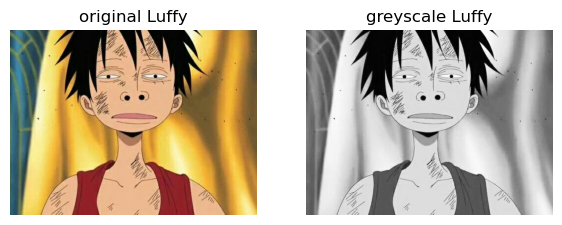

In [4]:
fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

grey_img = to_greyscale(img)

axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original Luffy")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale Luffy")

plt.show()

Now that we've converted our image of Luffy to a greyscaled version, we can do compute its SVD to generate a reconstructed image with less storage! 

## SVD Implementation

Here is the source code for my implementation of SVD: [SVD](https://github.com/kennyerss/kennyerss.github.io/blob/main/posts/unsupervised/svd.py)

In my source code, I implemented an `SVD` class containing two main methods: `svd_reconstruct` and `svd_experiment`.

Firstly, I can instantiate an SVD class two arguments to store as its attributes — the image to reconstruct and the number of `k` components the user wants to use to reconstruct the image. This is defined in the `__init__` method of the class.

    def __init__(self, img, k):
        self.img = img
        self.k = k

Next, I implemented a `svd_reconstruct` method that again takes in the image to reconstruct, `img`, and the `k` components to use. This method returns both the reconstructed image and the total storage needed for the reconstructed image. Shown below is my implementation of the method:

    def svd_reconstruct(self, img, k):
        '''
        Input: Image to reconstruct and number of k singular values to use
        Output: Reconstructs image from its singular value decomposition and storage amount
        '''
        # From lecture notes
        U, sigma, V = np.linalg.svd(img)
        
        # Create the D matrix in the SVD
        D = np.zeros_like(img,dtype=float) # matrix of zeros of same shape as img
        # Singular values on the main diagonal
        D[:min(img.shape),:min(img.shape)] = np.diag(sigma)      
        
        # Approximate using the first k columns of U, D, and V
        U_ = U[:, :k]
        D_ = D[:k, :k]
        V_ = V[:k, :]
        
        # Reconstruct our image 
        img_ = U_ @ D_ @ V_

        # Get the dimensions of our img
        m, n = img_.shape

        # Calculate the number of pixels to store for reconstructed image
        storage = ((k*m) + k + (k*n)) / (m*n) * 100

        return img_, round(storage, 1)
        
Most of the code in the `svd_reconstruct` method were taken from the assignment blog post — specifically reconstructing the image by generating the matrices `U`, `D`, and `V`. In sequential order, I took the first $k$ columns of $U$, the top $k$ singular values of $D$, and the first $k$ rows of $V$. I then computed a matrix multiplication using all three matrices to reconstruct our image `img_`. Next, I'll talk about how I calculated the storage needed to represent each reconstructed image. 

#### Amount of Storage for Reconstruction

To calculate the storage needed for a reconstructed image using some $k$ components, I used the information about how each matrix $U$, $D$, and $V$ are "indexed" from the $k$ singular values. 

Recall that for the original image, it takes $mn$ total pixels to represent the image, where $m$ and $n$ are the dimensions of the image ($m$ rows and $n$ columns). For the matrix $U$, taking its first $k$ columns will be represented by $km$ total pixels; similarly, taking the first $k$ rows of the matrix $V$ will be represented by $kn$ pixels. To find out the total pixels needed to represent the matrix $D$, I recognized that the matrix $D$ is a diagonal, square matrix — thus, we can represent and store the matrix using only $k$ pixels even though its dimensions are $k$ by $k$. Lastly, I divided the total pixels of the reconstructed image by $mn$ pixels, followed by a multiplication of $100$ to get its percentage of storage; I ended up rounding the storage by $1$ decimal point to keep the storage amount interpretable. 

This implementation is described in the code below:

    storage = ((k*m) + k + (k*n)) / (m*n) * 100

### Reconstructing an Image

Shown below is a demonstration of using the `svd_reconstruct` method to reconstruct an image of Luffy.

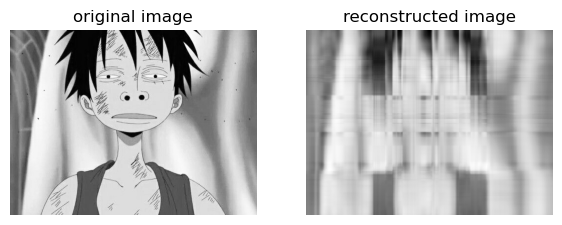

In [5]:
from svd import SVD
k = 5
SVD_ = SVD(grey_img, k)

# From lecture notes 
def compare_images(A, A_):

    fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

    axarr[0].imshow(A, cmap = "Greys")
    axarr[0].axis("off")
    axarr[0].set(title = "original image")

    axarr[1].imshow(A_, cmap = "Greys")
    axarr[1].axis("off")
    axarr[1].set(title = "reconstructed image")
    
img_, storage = SVD_.svd_reconstruct(grey_img, k) # Call function to reconstruct image

compare_images(grey_img, img_)

For this demonstration, I've chosen a $k$ value of $5$. Here, I've plotted both the original and reconstructed image using the `compare_images` function. Though we've successfully reconstructed our original image, it is not indistinguishable by eye that the image *is* indeed Luffy. 

In the next section, we'll experiment with different $k$ values using the `svd_experiment` method. Additionally, we'll observe where the $k$ threshold lies in determining a recognizable reconstructed image of Luffy. 

### Experimentation

The other `SVD` class method I've chosen to implement is `svd_experiment` as shown below. 

    def svd_experiment(self):
    '''
    Output: Plots out varied k singular values and its reconstructed images using SVD
    '''
    # Initialize how many rows and columns we want the subplot axes to have
    plt_row = 3
    plt_col = 3

    fig, axarr = plt.subplots(plt_row, plt_col, figsize = (12,6))

    # Plotting each new reconstructed image onto subplot
    for i in range(plt_row):
        for j in range(plt_col):
            img_, storage = self.svd_reconstruct(self.img, self.k)

            axarr[i, j].imshow(img_, cmap = "Greys")
            axarr[i, j].axis("off")
            axarr[i, j].set(title = f"{self.k} components, % storage = {storage}")

            # Update k value
            self.k += 5

    # Adjust spacing for each subplot
    plt.tight_layout()
    plt.show()

This method uses the attributes `img` and `k` initially instantiated when creating an object of the `SVD` class. For this experimentation, I've chosen to use the same $k$ value of $5$ as with my demonstration of `svd_reconstruct`. I fixed the dimensions of the axes of my subplots to be $3$ by $3$, so that I'll have at least $9$ reconstructed images of Luffy of increasing $k$ components and storage amount. Additionally, I chose to increase value of $k$ by $5$ after each iteration of my nested for loop.

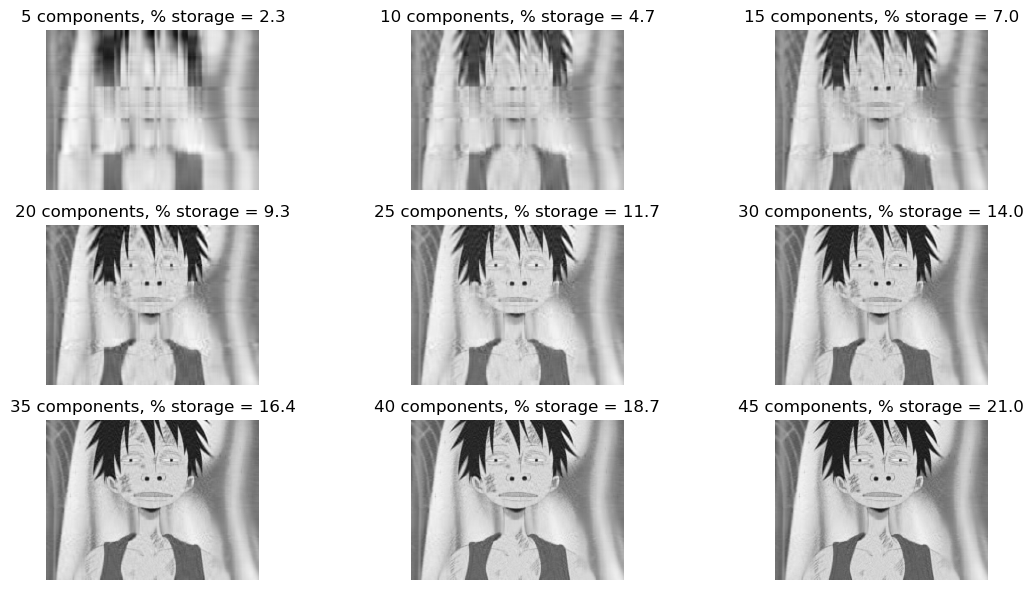

In [6]:
# Perform experiment
SVD_ = SVD(grey_img, k = 5)
SVD_.svd_experiment()

From my experiment, I plotted several reconstructed images of Luffy up to $45$ components starting at $5$ components. By observation, the reconstructed image becomes indistinguishable to the original greyscaled image around $30$ components. For the reconstructed image of $30$ components, we only needed to store around $14.0$% of the original storage amount. Hence, we've successfully compressed our original image to reduce the storage amount by $86.0$%!

# Spectral Community Detection

In this second half of the blog post, I'll be implementing the Laplacian spectral clustering algorithm as a method for finding interesting clusters in point cloud data sets by operating on a graph. Well, which graph? The **KARATE CLUB GRAPH**!

![](https://media2.giphy.com/media/PudZiAbQDUEik/giphy.gif)

The karate club graph is a graph representing a social network whose nodes represents an individual member of a karate club. Shown below, I've generated a karate club graph $G$ using the `networkx` package; the blue nodes represent the `Mr. Hi` club, and the orange nodes represent the `Officer` club.

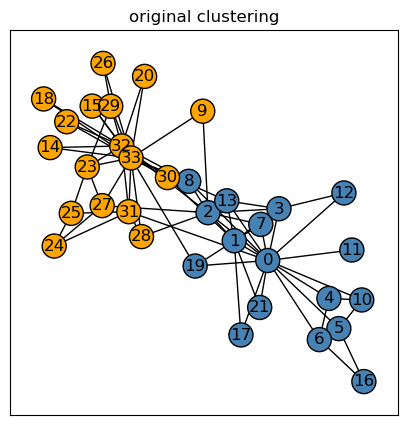

In [7]:
import networkx as nx
np.random.seed(12345) # For reproducibility

# From lecture notes to generate karate club graph
G = nx.karate_club_graph()
layout = nx.layout.fruchterman_reingold_layout(G)

clubs = nx.get_node_attributes(G, "club")

fig, axarr = plt.subplots(1, 1, figsize = (5,5))

nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black", # confusingly, this is the color of node borders, not of edges
        ax = axarr) 

axarr.set(title = "original clustering")
plt.show()

## Laplacian Spectral Clustering Implementation

To implement the Laplacian spectral clustering, recall in the lecture notes that the equation for the normalized random walk Laplacian is:

$$ L = D^{-1}[D-A] $$

Here, the matrix $D$ is the degree matrix obtained from the adjacency matrix $A$.

$$D = [\sum_{j=1}^{n} A_{i,j}]$$

We then use the normalized Laplacian matrix $L$ to choose some estimate $z$ to minimize the normcut that will split the karate club graph into binary labels corresponding to each node's club. From the lecture notes, we can find this estimated $z$ as the eigenvector of the normalized Laplacian matrix with the second-smallest eigenvalue.

In my implementation of the `spectral_clustering` function, I first extracted and symmetrized the adjacency matrix, $A$, from my karate club graph $G$. I then used this adjacency matrix to generate the degree matrix $D$ by taking the sum of $A$'s rows as its diagonal entries. 

Then, we can find the inverse of $D$ using the `numpy` operation`np.linalg.inv()` and calculate the normalized Laplacian matrix $L$ by doing a matrix multiplication between $D^{-1}$ and $D - A$.

I then found the eigenvalues and eigenvectors of $L$ using the numpy operation `np.linalg.eig()`. Since we want to choose the eigenvector corresponding to the second-smallest eigenvalue of $L$, I first sorted the eigenvalues by sorted indices in ascending order using the numpy operation `np.argsort`. Rather than sorting the eigenvalues by its values, I sorted them by indices to easily extract where the index of second-smallest eigenvalue will be. 

Lastly, I indexed the eigenvectors of $L$ up to the second-smallest index of the sorted indices in `sorted_eig`, which would just be at the $1$th index — finally, we've found our estimated cluster vector $z$! 

We can retrieve the final set of cluster labels by transforming $z$ as a vector of binary labels. This is done through the line of code: `1*(z_ > 0)` — which is just an implementation of the indicator function! 

In [11]:
def spectral_clustering(G):
    '''
    Input: Graph G
    Output: Vector of binary labels to split graph
    '''
    # Extract adjacency matrix from graph G
    A = nx.adjacency_matrix(G).toarray()
    # Symmetrize the matrix 
    A = A + A.T
    A[A > 1] = 1
    
    # D is the degree matrix obtained from the adjacency matrix
    D = np.diag(A.sum(axis=1))

    # Generate the normalized Laplacian matrix
    L = np.linalg.inv(D) @ (D-A)
    
    # Using np.linalg.eig to return eigenvalues and eigenvectors in ascending order
    eig_val, eig_vec = np.linalg.eig(L)
    
    # Sort eigenvalues in order to find index of the second smallest eigenvalue
    sorted_eig = np.argsort(eig_val)
    
    z_ = eig_vec[:, sorted_eig[1]] # Obtain the eigenvector with second smallest eigenvalue of L
    z = 1*(z_ > 0) # Transform into binary labels
    return z

### Plotting the Spectral Cluster

After implementing the Laplacian spectral clustering algorithm, we can now plot the set of spectral labels to determine how well its classified each node of the karate club graph.

Recall that for the binary cluster labels, $0$ represents the `Mr. Hi` club, and a $1$ would represent the `Officer` club.

In [9]:
# Generate our cluster labels
# 0: "Mr. Hi", 1: "Officer"
cluster_labels = spectral_clustering(G)

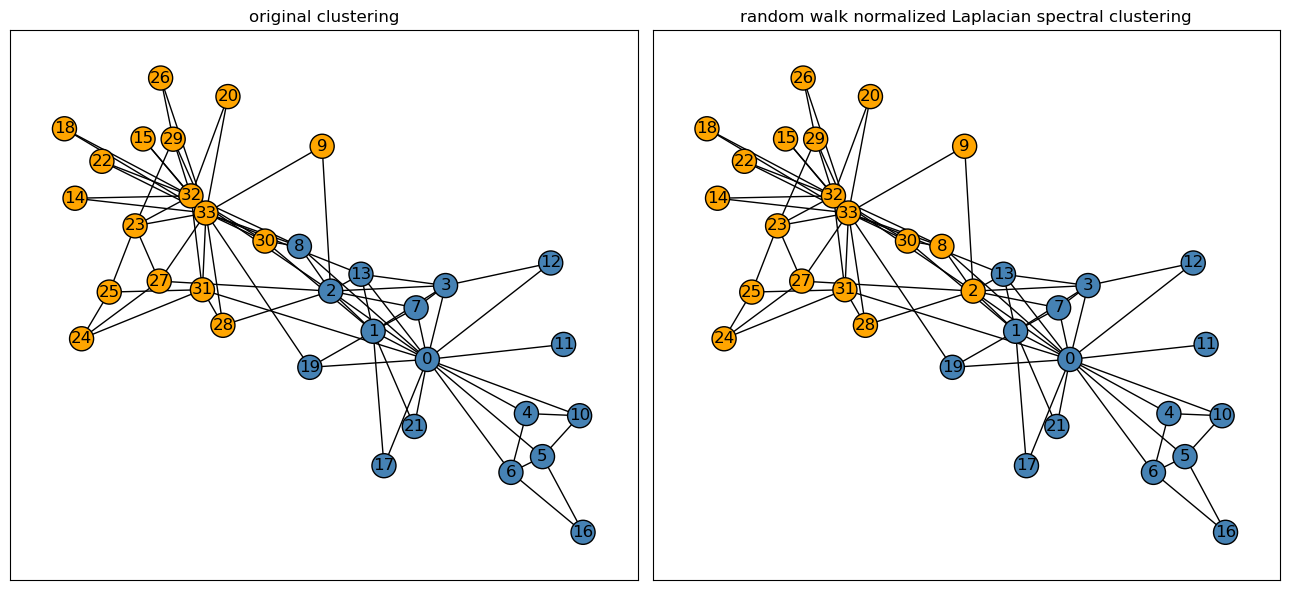

In [10]:
# Plotting each graph side by side
fig, axarr = plt.subplots(1, 2, figsize = (13,6))

# Original graph
nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black",
        ax = axarr[0]) 

# Spectral graph with random walk normalized Laplacian
nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if i == 1 else "steelblue" for i in cluster_labels],
        edgecolors = "black",
        ax = axarr[1]) 

# Set graph titles 
axarr[0].set(title = "original clustering")
axarr[1].set(title = "random walk normalized Laplacian spectral clustering")

plt.tight_layout()
plt.show()

After plotting both the original clustering and the random walk normalized Laplacian spectral clustering of our graph $G$, we observed that our spectral clustering does significantly well in dividing the graph into similar clusters as found by the original clustering. Only two nodes out of 34, the $8th$ and $2nd$ nodes, were misclassified as part of the `Officer` club by the spectral clustering algorithm. Thus, the algorithm's misclassification rate in divding the graph into each respective club is only about $6$% — pretty good!

Since the two nodes are right in the middle of the graph, it would be reasonable that our algorithm is unable to correctly classify the two nodes' clubs. 